# Notebook for non-kernel models

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, make_scorer, fbeta_score

from scripts.nested_CV import nested_cv

In [14]:
# configs
seed = 42  # for repeatability

fbeta_scorer = make_scorer(fbeta_score, beta=2, pos_label=-1)

### Data import and preprocessing

In [15]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)

print(X.shape, y.shape)

(200, 60) (200,)


In [16]:
# normalizing the data and splitting into train/test splits
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

## Baseline 1: Linear Classification - No regularization (Ordinary Least squares)

### Tuning and Evaluation

There are no hyperparameters to tune here. To evaluate the model, we just use plain simple cross valdiation (Kfold) to estimate the accuracy and more importantly the recall of the negative class 

In [17]:
clf_ols = LinearRegression()
clf_ols.fit(X_train, y_train)
y_pred = clf_ols.predict(X_test)
y_class = np.where(y_pred >= 0, 1, -1)
print(classification_report(y_test, y_class))

              precision    recall  f1-score   support

          -1       0.80      0.94      0.86        17
           1       0.95      0.83      0.88        23

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40



In [18]:
scores = cross_val_score(LinearRegression(), X, y, scoring='neg_mean_squared_error', cv=5)
print(scores.mean())

-0.5144542261404567


## Baseline 2: Logistic Regression

### Description
Regression, that uses the sigmoid function as the decision function to classify instances. It uses the logistic loss and we use the L2 penalty here.

Sigmoid function:
$$
f_{\theta}(x) = \frac {1}{1+e^{-x}}
$$

Logistic loss:
$$
\mathcal{l}_{\text log}(f_{\theta (x_{\text i}), y_{\text i}}) = log(1+e^{-y_{i} f_{\theta}(x_{i})})

$$

### Tuning
We tune for the $f_{\beta}$ (formula given below) score of the negative class, with $\beta = 2$ (i.e. recall is twice as important as precision), under the assumption that shipping a medical grade laser is more expensive than re-testing and/or repairing it. Therefore, it's better to identify as many faulty lasers as possible, even if it means re-testing some positive ones. 

$$
f_{\beta} =\frac {\beta^{2} + 1}  {\beta^{2} \cdot recall^{-1} + precision^{-1}} = \frac {1+\beta^{2} \cdot precision \cdot recall} {(\beta^{2} \cdot precision) + recall}
$$

#### Nested Cross Validation
Here is a visual explanation of nested cross validation: <br>
![image](../diagrams/nested.jpg)

The `nested_cv` function performs nested cross validation, with 5 outer and 5 inner loops and is abstracted away at `src/scripts/nested_CV.py`

In [19]:
param_grid_log = {
    'C' : np.logspace(-3,3,7)
}
results = nested_cv(LogisticRegression(penalty='l2'), X, y, param_grid=param_grid_log, scoring=fbeta_scorer, random_state=seed)

print(">>>>RESULTS<<<<")
print("Mean f2 score (of negative class) over 5 by 5 rounds of Nested CV ", results["mean_score"])
print("Best parameters ", results["star_params"])

>>>>RESULTS<<<<
Mean f2 score (of negative class) over 5 by 5 rounds of Nested CV  0.9193507586052723
Best parameters  {'C': 0.1}


In [20]:
clf_log = LogisticRegression(C=.1)
clf_log.fit(np.delete(X, [35, 162], axis=0), np.delete(y, [35,162], axis=0))

odd_laser_faulty = clf_log.predict([X[35]])
odd_laser_non_faulty = clf_log.predict([X[162]])
print(odd_laser_faulty, odd_laser_non_faulty)

[-1] [-1]


## BUT ..... 

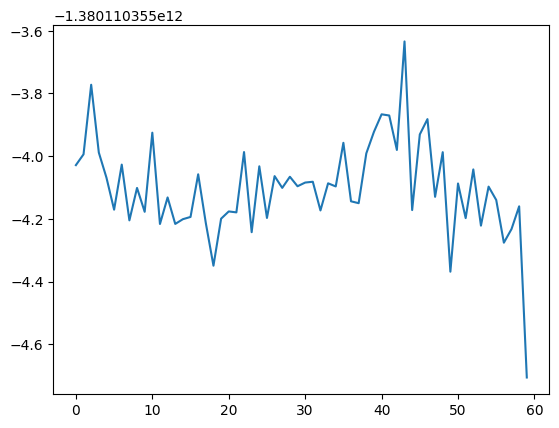

In [21]:
plt.plot(clf_ols.coef_)

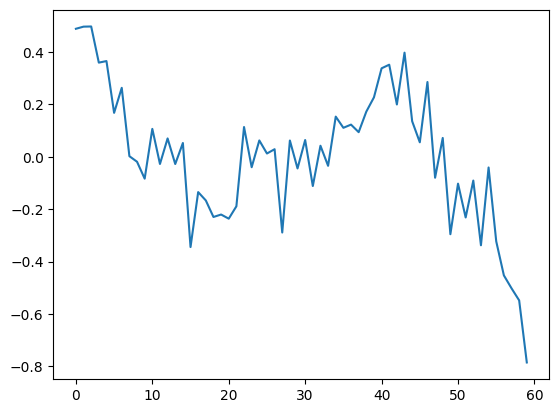

In [22]:
plt.plot(clf_log.coef_[0])